# Classification

**Brief**: Predict which customers will buy a limited-edition jumper.

### 1. Import statements

In [1]:
import pandas as pd # Data manipulation

import seaborn as sns # Visualisation

# Split data to allow testing

from sklearn.model_selection import train_test_split

# Build and visualise decision trees

from sklearn.tree import DecisionTreeClassifier, export_graphviz

# Evaluate decision trees

from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

# Visualise decision trees

import graphviz

### 2. Loading the data

In [2]:
# Load from .csv in same directory as notebook

data = pd.read_csv("customer_data.csv")

### 3. Exploring the data

In [3]:
# Number of rows and columns

data.shape

(701, 9)

In [4]:
# Random five rows

data.sample(5)

,age,gender,No_jumpers_per_year,spent_today,spent,salaRy,Distance,Online,Decision
239,25,Male,2,60,195,46533,3.131778,0,NaN
562,26,male,4,49,191,70712,8.731732,1,1.0
361,28,female,3,43,140,55089,2.464305,1,1.0
538,46,female,4,26,28,11387,5.922984,0,0.0
372,22,Male,3,39,130,71302,3.067975,0,NaN


In [5]:
# Column names

data.columns

Index(['age', 'gender', 'No_jumpers_per_year', 'spent_today', 'spent',
       'salaRy', 'Distance', 'Online', 'Decision'],
      dtype='object')

In [6]:
# Summary stats (including NaNs)

data.describe(include="all")

,age,gender,No_jumpers_per_year,spent_today,spent,salaRy,Distance,Online,Decision
count,701.000000,701,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000,473.000000
unique,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34.164051,NaN,2.707561,32.844508,107.834522,43860.815977,4.550152,0.532097,0.638478
std,13.777421,NaN,1.592415,15.741395,55.338217,26188.806959,3.109289,0.499325,0.480950
min,16.000000,NaN,0.000000,0.000000,0.000000,1617.000000,0.003168,0.000000,0.000000
25%,23.000000,NaN,1.000000,24.000000,62.000000,22819.000000,1.876145,0.000000,0.000000
50%,28.000000,NaN,3.000000,36.000000,113.000000,42027.000000,4.185417,1.000000,1.000000
75%,46.000000,NaN,4.000000,43.000000,150.000000,60228.000000,6.696573,1.000000,1.000000


In [7]:
# Datatypes

data.dtypes

age                      int64
gender                  object
No_jumpers_per_year      int64
spent_today              int64
spent                    int64
salaRy                   int64
Distance               float64
Online                   int64
Decision               float64
dtype: object

In [8]:
# General information

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 9 columns):
age                    701 non-null int64
gender                 701 non-null object
No_jumpers_per_year    701 non-null int64
spent_today            701 non-null int64
spent                  701 non-null int64
salaRy                 701 non-null int64
Distance               701 non-null float64
Online                 701 non-null int64
Decision               473 non-null float64
dtypes: float64(2), int64(6), object(1)
memory usage: 49.4+ KB


In [9]:
# Number of NAs per column

data.isna().sum()

age                      0
gender                   0
No_jumpers_per_year      0
spent_today              0
spent                    0
salaRy                   0
Distance                 0
Online                   0
Decision               228
dtype: int64

### 4. Cleaning the data

Our initial exploration has revealed several problems that need fixing: unclear/inconsistent column names, inconsistent strings in `Gender`, and many `NaN`s.

In [10]:
# Rename columns to be clear and consistent

data.rename(columns={"No_jumpers_per_year":"jumpers_per_year",
                     "spent":"spent_month", "salaRy":"salary",
                     "Distance":"distance", "online":"online",
                     "Decision":"decision"}, inplace=True)

In [11]:
# Look at the unique values in "gender"

data["gender"].unique()

array(['female', 'M', 'male', 'Female', 'Male', 'm'], dtype=object)

In [12]:
# Replace all matching values with "M" and "F"

data["gender"] = data["gender"].replace(to_replace=["Male","male","m"],
                                        value="M")

data["gender"] = data["gender"].replace(to_replace=["Female","female","f"],
                                        value="F")

In [13]:
# Replace all the 1.0 and 0.0 values in "decision" with "Y" and "N"

data["decision"] = data["decision"].replace(0.0, "N")
data["decision"] = data["decision"].replace(1.0, "Y")

We do need to remove all the `NaN`s before building our model, but we don't want to drop them - the `NaN`s aren't bad data, they're just unlabelled data. 

As there are only `NaN` values in the column we are trying to predict, we can keep those rows to one side while building the model, and then actually run them through the model at the end - using our model (built using labelled data) to predict the unlabelled data.

In [14]:
# Split the data into labelled and unlabelled sets

# Make a copy without any NaNs

labelled = data.dropna()

# Make a copy consisting only of rows where "decision" is NaN

unlabelled = data[data["decision"].isna()]

### 5. Visualising the data

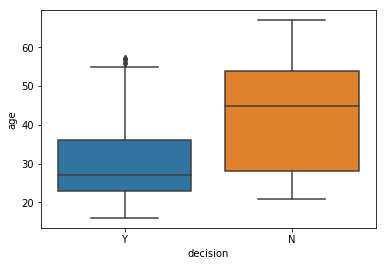

In [15]:
# Create a boxplot using age and decision

sns.boxplot(y="age", x="decision", data=labelled)

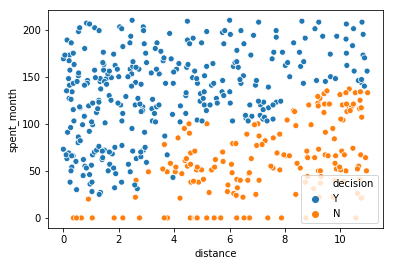

In [16]:
# Create a scatterplot using spent_month and distance, colouring data
# points with decision

sns.scatterplot(x="distance",y="spent_month", hue="decision",data=labelled)

### 6. Transforming the data

In order to effectively build our model, we need to transform the cleaned data in three ways:

1. split the predictors from the predictee

2. Convert all non-numeric columns to numeric

3. Split the data into train and test sets

In [17]:
# Separate the column to be predicted (the class/target/dependent
# variable) from the predicting columns (the feature/independent
# variables)

target = labelled[['decision']]
predictors = labelled.drop(columns=['decision'], axis=1)

In [18]:
# One-hot encode the predictors, converting all non-numeric columns
# into sets of colums with binary values
# "gender", with "M" and "F" values becomes "gender_F" and "gender_M"
# Each new column only contains 0s and 1s.

predictors = pd.get_dummies(predictors)

In [19]:
# Inspect the new predictors data frame, seeing how the columns have changed

predictors.tail()

,age,jumpers_per_year,spent_today,spent_month,salary,distance,Online,gender_F,gender_M
695,55,5,39,114,53585,10.355656,1,0,1
696,29,5,20,74,29799,10.455068,0,1,0
697,45,5,61,201,80260,10.476341,0,1,0
698,54,5,44,116,44077,10.693889,1,0,1
699,63,5,33,117,43081,10.755194,1,0,1


In [20]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(predictors, target,
                                                    test_size=0.2,
                                                    random_state=42)

### 7. Building the model

In [21]:
# Create the model

model = DecisionTreeClassifier()

# Train the model on the training data, building the actual tree

model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 8. Visualising the model

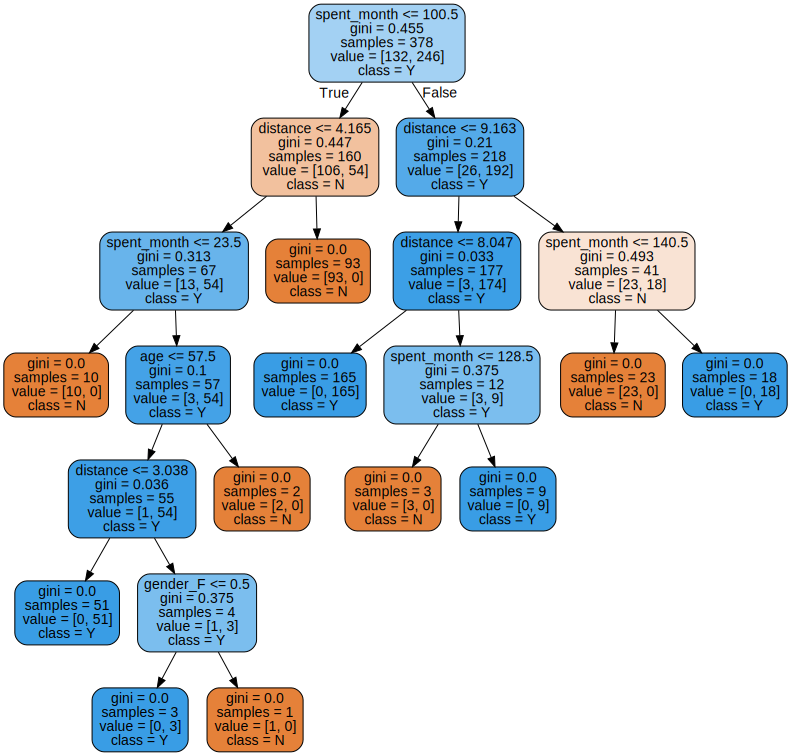

In [22]:
# convert the tree into a graph
# class_names and feature_names add labels to the tree so it is more readable
# filled and rounded are just for styling

tree_graph = export_graphviz(model, out_file=None,
                             filled=True, rounded=True,
                             class_names=["N","Y"],
                             feature_names=predictors.columns)

# Actually display the graph

graphviz.Source(tree_graph)

### 9. Evaluating the model

In [23]:
# Make predictions using the test data

predictions = model.predict(X_test)

In [24]:
# Put the predictions and the actual results into the same dataframe

# Make a copy of y_test
results = y_test.copy()

# Add the matching set of predictions as a column
results['predicted'] = predictions

# rename the columns for clarity

results.columns = ["actual","predicted"]

In [25]:
# Inspect the new data frame

results.sample(5)

,actual,predicted
448,N,N
545,Y,Y
111,N,N
430,Y,Y
588,Y,Y


In [26]:
# Get the accuracy score of the model

accuracy_score(results['predicted'],results['actual'])

0.9578947368421052

In [27]:
# Get a confusion matrix, showing more detail

# Convert the confusion matrix to a dataframe

confusion_df = pd.DataFrame(confusion_matrix(results['actual'],results['predicted']),
                            index=["N","Y"], columns=["N","Y"])

# Display the confusion matrix

confusion_df

# x-axis is predicted, y-axis is actual
# This means that the top left is the number of times N was both the actual and predicted value,
# while the bottom left is the number of times Y was predicted but the actual was N.

,N,Y
N,36,3
Y,1,55


This table below demonstrates the structure of a confusion matrix:

| Predicted| N | Y |
| --- | --- | --- |
| **Actual** |
| **N** | True Negative | False Positive |
| **Y** | False Negative | True Positive |

In [28]:
# Create a classification report
# It has to be printed so it is easily readable

print(classification_report(results['actual'],results['predicted']))

              precision    recall  f1-score   support

           N       0.97      0.92      0.95        39
           Y       0.95      0.98      0.96        56

   micro avg       0.96      0.96      0.96        95
   macro avg       0.96      0.95      0.96        95
weighted avg       0.96      0.96      0.96        95



### 10. Improving the model

The model created in section 8 is a very basic one, using only the default options. In order to increase the accuracy, reliability, and generalisability of the model, these parameters can be altered.

It's worth experimenting with the parameters and seeing how they affect the result. 

### 11. Making predictions on unlabelled data

In [29]:
# Drop the decision column from unlabelled

unlabelled = unlabelled.drop('decision', axis=1)

# Run the same one-hot encoding as for the labelled data

unlabelled = pd.get_dummies(unlabelled)

# Generate predictions for unlabelled and add them to the dataframe as a column

unlabelled['prediction'] = model.predict(unlabelled)

In [30]:
# Count the number of customers in unlabelled who are in each category (buy/not buy)

unlabelled['prediction'].value_counts()

Y    180
N     48
Name: prediction, dtype: int64